<a href="https://colab.research.google.com/github/daichisaito-cs/glasses_shape_classification/blob/main/glasses_shape_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reference

In [ ]:
# https://www.kaggle.com/datasets/zeyadkhalid/faceshape-processed/data
# https://www.kaggle.com/code/zeyadkhalid/face-shape-recognition-73-accuracy

# Setup

In [ ]:
# driveのマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q wandb

In [ ]:
import os

ROOT_PATH = '/content/drive/Shareddrives/inSane/Workspace/EyeJapan'
DATASET_PATH = os.path.join(ROOT_PATH, 'data/glasses_shape_dataset')

In [ ]:
!ls {DATASET_PATH}

boston	leaderboard.gsheet  oval  square  wellington


# Traning

In [ ]:
# @title WandB

import wandb

wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [110]:
# @title data_loader.py
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
from transformers import CLIPModel, CLIPProcessor
import torch
from PIL import Image
import os
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, processor, transform=None):
        self.root_dir = root_dir
        self.processor = processor
        self.transform = transform  # 追加の変換がある場合
        self.classes = ['oval', 'wellington', 'square', 'boston']
        self.class_to_idx = {cls.lower(): idx for idx, cls in enumerate(self.classes)}

        self.images = []
        self.labels = []

        for class_name in self.classes:
            class_dir = os.path.join(self.root_dir, class_name)
            if os.path.exists(class_dir):
                for img_name in os.listdir(class_dir):
                    if img_name.endswith(('.jpg', '.jpeg', '.png')):
                        self.images.append(os.path.join(class_dir, img_name))
                        self.labels.append(self.class_to_idx[class_name.lower()])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')

        # CLIPの前処理
        processed = self.processor(
            images=image,
            return_tensors="pt",
            do_rescale=True
        )
        image_tensor = processed['pixel_values'].squeeze(0)

        # 追加の変換がある場合は適用
        if self.transform:
            image_tensor = self.transform(image_tensor)

        return image_tensor, self.labels[idx]

def create_data_loaders(data_dir, processor, batch_size=32, valid_ratio=0.15, test_ratio=0.15):
    """データセットを train/valid/test に分割してデータローダーを作成する関数
    val/testセットでは各クラスのサンプル数を揃え、余りはtrainに含める
    """
    # 全データセットを読み込む
    full_dataset = CustomImageDataset(data_dir, processor)

    # ラベルを numpy 配列として取得
    labels = np.array(full_dataset.labels)
    unique_labels = np.unique(labels)
    all_indices = np.arange(len(labels))

    # 各クラスごとのサンプル数を取得
    label_counts = {label: np.sum(labels == label) for label in unique_labels}
    total_samples = len(labels)

    # 全体のvalidとtestのサンプル数を計算
    target_valid_size = int(total_samples * valid_ratio)
    target_test_size = int(total_samples * test_ratio)

    # クラスあたりのサンプル数を計算（クラス数で割る）
    samples_per_class_valid = target_valid_size // len(unique_labels)
    samples_per_class_test = target_test_size // len(unique_labels)

    valid_indices = []
    test_indices = []
    train_indices = []

    # 各クラスについてサンプルを分割
    for label in unique_labels:
        # 該当クラスのインデックスを取得
        label_indices = all_indices[labels == label]

        # ランダムにシャッフル
        np.random.seed(42)
        shuffled_indices = np.random.permutation(label_indices)

        # validとtestに割り当て
        valid_indices.extend(shuffled_indices[:samples_per_class_valid])
        test_indices.extend(shuffled_indices[samples_per_class_valid:samples_per_class_valid + samples_per_class_test])
        train_indices.extend(shuffled_indices[samples_per_class_valid + samples_per_class_test:])

    # Subset作成
    train_dataset = torch.utils.data.Subset(full_dataset, train_indices)
    valid_dataset = torch.utils.data.Subset(full_dataset, valid_indices)
    test_dataset = torch.utils.data.Subset(full_dataset, test_indices)

    print("Train set:")
    print_class_distribution(train_dataset)
    print("\nValidation set:")
    print_class_distribution(valid_dataset)
    print("\nTest set:")
    print_class_distribution(test_dataset)

    # データローダーの作成
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, valid_loader, test_loader

def print_class_distribution(dataset):
    labels = np.array(dataset.dataset.labels)[dataset.indices]
    unique, counts = np.unique(labels, return_counts=True)
    dist = dict(zip(unique, counts))
    print("Class distribution:", dist)
    print("Total samples:", sum(counts))

SyntaxError: '(' was never closed (<ipython-input-110-cbf0866b830a>, line 94)

In [ ]:
# @title utils.py

import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import random

def predict_one_shot(model, image_path, processor, device='cuda'):
    """1枚の画像に対して予測を行う関数"""
    # モデルを評価モードに
    model.eval()

    try:
        image = Image.open(image_path).convert('RGB')

        # CLIPプロセッサーで画像を処理
        processed = processor(
            images=image,
            return_tensors="pt",
            do_rescale=True
        )

        # 画像をデバイスに送る
        image_tensor = processed['pixel_values'].to(device)

        # 予測
        with torch.no_grad():
            outputs = model(image_tensor)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)

            # 最も確率の高いクラスとその確率を取得
            prob, predicted = torch.max(probabilities, 1)

            # クラス名を取得
            class_names = model.class_names
            predicted_class = class_names[predicted.item()]
            confidence = prob.item()

            # すべてのクラスの確率を辞書に格納
            all_probabilities = {
                class_name: round(prob.item() * 100, 2)
                for class_name, prob in zip(class_names, probabilities[0].cpu().numpy())
            }

            return {
                'predicted_class': predicted_class,
                'confidence': round(confidence * 100, 2),
                'all_probabilities': all_probabilities
            }

    except Exception as e:
        return {
            'error': str(e)
        }

def load_model(model, checkpoint_path, device='cuda'):
    """保存されたモデルをロードする関数"""
    # モデルの初期化

    # チェックポイントの読み込み
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # モデルの重みをロード
    model.load_state_dict(checkpoint['model_state_dict'])

    # デバイスに移動
    model = model.to(device)

    # 評価モードに設定
    model.eval()

    print(f"Loaded model from epoch {checkpoint['epoch']+1} with validation accuracy: {checkpoint['val_acc']:.2f}%")

    return model

# モデルのパラメータ数を表示
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# シード固定
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed()

In [81]:
# @title model.py

import torch.nn as nn
from transformers import CLIPModel

class ShapeClassifierBase(nn.Module):
    def __init__(self, class_names, num_classes, dropout_rate=0.2):
        super().__init__()
        self.class_names = class_names
        self.clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

        self.classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            # 出力層
            nn.Linear(128, num_classes)
        )

        # CLIPのパラメータを凍結
        for param in self.clip.parameters():
            param.requires_grad = False

    def forward(self, x):
        features = self.clip.get_image_features(x)
        outputs = self.classifier(features)
        return outputs

class GlassesClassifier(ShapeClassifierBase):
    def __init__(self, num_classes=4, dropout_rate=0.5):
        glass_classes = ['oval', 'wellington', 'square', 'boston']
        super().__init__(glass_classes, num_classes, dropout_rate)

# class FaceClassifier(ShapeClassifierBase):
#     def __init__(self, num_classes=4):
#         face_classes = ['square', 'oblong', 'round', 'heart']
#         super().__init__(face_classes, num_classes)

# class GlassesDetector(ShapeClassifierBase):
#     def __init__(self):
#         glass_detection_classes = ['wearing_glasses', 'no_glasses']
#         super().__init__(glass_detection_classes, num_classes=2)

In [83]:
# @title train.py

from tqdm import tqdm

def train_model(model, train_loader, optimizer, criterion, device, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # (images, labels) のみを受け取るように修正
    for batch_idx, (images, labels) in tqdm(
        enumerate(train_loader),
        total=len(train_loader),
        desc=f"Epoch {epoch}"
    ):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        if (batch_idx + 1) % 10 == 0:
            wandb.log({
                "batch": batch_idx + 1,
                "batch_loss": loss.item(),
                "batch_acc": 100. * correct / total
            })

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc

In [84]:
# @title validate.py

def validate_model(model, valid_loader, criterion, device, epoch, split="valid"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        # (images, labels) のみを受け取るように修正
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = running_loss / len(valid_loader)
    val_acc = 100. * correct / total

    wandb.log({
        f"{split}_loss": val_loss,
        f"{split}_accuracy": val_acc,
        "epoch": epoch
    })

    return val_loss, val_acc

In [85]:
# @title test.py

def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        # (images, labels) のみを受け取るように修正
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = outputs.max(1)

            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    accuracy = 100. * correct / total

    wandb.log({
        "confusion_matrix": wandb.plot.confusion_matrix(
            probs=None,
            y_true=all_targets,
            preds=all_predictions
        )
    })

    return accuracy, all_predictions, all_targets

In [86]:
# @title early_stopping.py

class EarlyStopping:
    """Early Stoppingを制御するクラス"""
    def __init__(self, patience=7, min_delta=0, verbose=True):
        self.patience = patience  # 改善が見られるのを待つエポック数
        self.min_delta = min_delta  # 改善とみなす最小変化量
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.val_loss_min = float('inf')

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

=== Dataset Analysis ===

Total samples: 925

Class distribution:
oval: 167 (18.1%)
wellington: 250 (27.0%)
square: 255 (27.6%)
boston: 253 (27.4%)


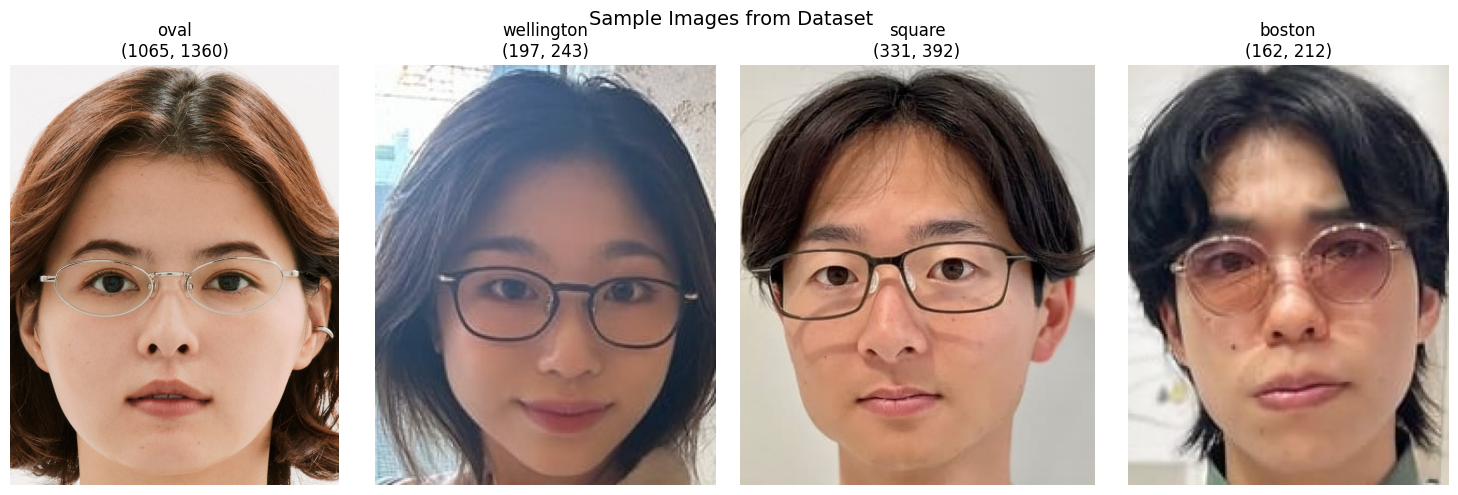

In [87]:
# @title dataset_info.py
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

def analyze_dataset(data_dir):
    """データセットの情報を分析して表示する関数"""
    set_seed(42)
    classes = ['oval', 'wellington', 'square', 'boston']
    dataset_info = {}

    # データセット全体の情報を収集
    class_counts = {}
    total_samples = 0
    sample_paths = {}  # 各クラスのサンプル画像パスを保存

    for class_name in classes:
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.exists(class_dir):
            print(f"Warning: {class_dir} does not exist")
            class_counts[class_name] = 0
            continue

        # 画像ファイルをカウント
        images = [f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
        class_counts[class_name] = len(images)
        total_samples += len(images)

        # ランダムな選択を固定
        if images:
            random_idx = random.randint(0, len(images) - 1)
            sample_paths[class_name] = os.path.join(class_dir, images[random_idx])

    dataset_info = {
        'total': total_samples,
        'class_counts': class_counts,
        'sample_paths': sample_paths
    }

    # 情報の表示
    print("=== Dataset Analysis ===")
    print(f"\nTotal samples: {dataset_info['total']}")
    print("\nClass distribution:")
    for class_name, count in dataset_info['class_counts'].items():
        percentage = (count / dataset_info['total'] * 100) if dataset_info['total'] > 0 else 0
        print(f"{class_name}: {count} ({percentage:.1f}%)")

    # サンプル画像の表示
    fig = plt.figure(figsize=(15, 5))
    fig.suptitle("Sample Images from Dataset", fontsize=14)

    for i, class_name in enumerate(classes, 1):
        if class_name in dataset_info['sample_paths']:
            plt.subplot(1, 4, i)
            img_path = dataset_info['sample_paths'][class_name]
            img = Image.open(img_path)
            plt.imshow(img)
            plt.title(f"{class_name}\n{img.size}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

    return dataset_info

# データセットの分析を実行
dataset_info = analyze_dataset(DATASET_PATH)

In [96]:
# @title main.py

from datetime import datetime
import wandb
import pytz
from torch import optim
import torch.nn as nn
import os

def run_training(model, train_loader, valid_loader, test_loader,
                num_epochs, patience, lr, device='cuda'):
    """Early Stopping機能を追加した学習管理関数"""

    # 日本時間で現在の時刻を取得
    jst = pytz.timezone('Asia/Tokyo')
    current_time = datetime.now(jst).strftime("%Y-%m-%d_%H-%M-%S")

    # チェックポイント保存用のディレクトリ作成
    base_checkpoint_dir = 'checkpoints'
    os.makedirs(base_checkpoint_dir, exist_ok=True)

    # current_time のサブディレクトリを作成
    save_dir = os.path.join(base_checkpoint_dir, current_time)
    os.makedirs(save_dir, exist_ok=True)

    wandb.init(
        project="glasses-shape-classification",
        name=f"run-{current_time}",
        config={
            "architecture": model.__class__.__name__,
            "dataset": "glasses_shapes",
            "epochs": num_epochs,
            "batch_size": train_loader.batch_size,
            "optimizer": "Adam",
            "learning_rate": lr,
            "early_stopping_patience": patience
        }
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=lr)
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    best_val_acc = 0
    best_val_loss = float('inf')
    best_model_path_loss = None
    best_model_path_acc = None

    for epoch in range(num_epochs):
        # 学習
        train_loss, train_acc = train_model(
            model, train_loader, optimizer, criterion, device, epoch
        )

        # 検証
        val_loss, val_acc = validate_model(
            model, valid_loader, criterion, device, epoch
        )

        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

        # モデルの保存
        if val_acc > best_val_acc:
            best_val_acc = val_acc

            # 以前のベストモデルを削除
            if best_model_path_acc and os.path.exists(best_model_path_acc):
                os.remove(best_model_path_acc)

            # 新しいベストモデルを保存
            best_model_path_acc = os.path.join(save_dir, f'best_model_acc_epoch_{epoch+1}.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'val_acc': val_acc,
            }, best_model_path_acc)

            print(f'Model saved to {best_model_path_acc} with validation accuracy: {val_acc:.2f}%')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            if best_model_path_loss and os.path.exists(best_model_path_loss):
                os.remove(best_model_path_loss)

            best_model_path_loss = os.path.join(save_dir, f'best_model_loss_epoch_{epoch+1}.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'val_acc': val_acc,
            }, best_model_path_loss)

            print(f'Model saved to {best_model_path_loss} with validation loss: {val_loss:.4f}')

        # Early Stoppingの判定
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break

    # 最良のモデルを読み込む
    if best_model_path_acc:
        checkpoint = torch.load(best_model_path_acc)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f'Loaded best acc model from epoch {checkpoint["epoch"]+1} '
              f'with validation accuracy: {checkpoint["val_acc"]:.2f}%')

    # テストデータで評価
    test_acc, predictions, targets = test_model(model, test_loader, device)
    print(f'\nFinal Test Accuracy with Best Acc Model: {test_acc:.2f}%')

    if best_model_path_loss:
        checkpoint = torch.load(best_model_path_loss)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f'Loaded best loss model from epoch {checkpoint["epoch"]+1} '
              f'with validation loss: {checkpoint["val_loss"]:.4f}')

    test_acc, predictions, targets = test_model(model, test_loader, device)
    print(f'\nFinal Test Accuracy with Best Loss Model: {test_acc:.2f}%')

    wandb.finish()
    return model, best_model_path_acc, best_model_path_loss, save_dir  # save_dirも返すように変更

set_seed(42)

# モデルとデータの準備
model = GlassesClassifier(num_classes=4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# プロセッサーの取得
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# データローダーの作成
train_loader, valid_loader, test_loader = create_data_loaders(
    DATASET_PATH,
    processor=processor,
    batch_size=32
)

# 学習の実行（Early Stoppingのパラメータを指定可能）
trained_model, best_model_path_acc, best_model_path_loss, checkpoint_dir = run_training(
    model,
    train_loader,
    valid_loader,
    test_loader,
    num_epochs=200,
    patience=7,
    lr=0.0001,
    device=device
)

print(f"Checkpoints saved in: {checkpoint_dir}")

Train set:
Class distribution: {0: 99, 1: 182, 2: 187, 3: 185}
Total samples: 653

Validation set:
Class distribution: {0: 34, 1: 34, 2: 34, 3: 34}
Total samples: 136

Test set:
Class distribution: {0: 34, 1: 34, 2: 34, 3: 34}
Total samples: 136


batch,▁█▁█
batch_acc,▁▂▇█
batch_loss,█▃▅▁
epoch,▁█
valid_accuracy,▁█
valid_loss,█▁
batch,20
batch_acc,30.46875
batch_loss,1.30164
epoch,1
valid_accuracy,40.44118


Epoch 0: 100%|██████████| 21/21 [00:10<00:00,  2.07it/s]



Epoch 1/200:
Train Loss: 1.5296, Train Acc: 19.75%
Val Loss: 1.3743, Val Acc: 27.94%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_acc_epoch_1.pth with validation accuracy: 27.94%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_loss_epoch_1.pth with validation loss: 1.3743


Epoch 1: 100%|██████████| 21/21 [00:11<00:00,  1.84it/s]



Epoch 2/200:
Train Loss: 1.3911, Train Acc: 30.78%
Val Loss: 1.3229, Val Acc: 40.44%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_acc_epoch_2.pth with validation accuracy: 40.44%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_loss_epoch_2.pth with validation loss: 1.3229


Epoch 2: 100%|██████████| 21/21 [00:11<00:00,  1.76it/s]



Epoch 3/200:
Train Loss: 1.3440, Train Acc: 34.46%
Val Loss: 1.2779, Val Acc: 44.85%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_acc_epoch_3.pth with validation accuracy: 44.85%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_loss_epoch_3.pth with validation loss: 1.2779


Epoch 3: 100%|██████████| 21/21 [00:12<00:00,  1.74it/s]



Epoch 4/200:
Train Loss: 1.2966, Train Acc: 41.81%
Val Loss: 1.2480, Val Acc: 48.53%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_acc_epoch_4.pth with validation accuracy: 48.53%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_loss_epoch_4.pth with validation loss: 1.2480


Epoch 4: 100%|██████████| 21/21 [00:11<00:00,  1.79it/s]



Epoch 5/200:
Train Loss: 1.2374, Train Acc: 46.55%
Val Loss: 1.2207, Val Acc: 47.79%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_loss_epoch_5.pth with validation loss: 1.2207


Epoch 5: 100%|██████████| 21/21 [00:11<00:00,  1.82it/s]



Epoch 6/200:
Train Loss: 1.1934, Train Acc: 47.47%
Val Loss: 1.2029, Val Acc: 50.74%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_acc_epoch_6.pth with validation accuracy: 50.74%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_loss_epoch_6.pth with validation loss: 1.2029


Epoch 6: 100%|██████████| 21/21 [00:12<00:00,  1.69it/s]



Epoch 7/200:
Train Loss: 1.1897, Train Acc: 48.55%
Val Loss: 1.1893, Val Acc: 49.26%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_loss_epoch_7.pth with validation loss: 1.1893


Epoch 7: 100%|██████████| 21/21 [00:11<00:00,  1.84it/s]



Epoch 8/200:
Train Loss: 1.1362, Train Acc: 53.14%
Val Loss: 1.1747, Val Acc: 52.21%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_acc_epoch_8.pth with validation accuracy: 52.21%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_loss_epoch_8.pth with validation loss: 1.1747


Epoch 8: 100%|██████████| 21/21 [00:11<00:00,  1.79it/s]



Epoch 9/200:
Train Loss: 1.1335, Train Acc: 51.45%
Val Loss: 1.1616, Val Acc: 49.26%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_loss_epoch_9.pth with validation loss: 1.1616


Epoch 9: 100%|██████████| 21/21 [00:10<00:00,  1.91it/s]



Epoch 10/200:
Train Loss: 1.0340, Train Acc: 58.35%
Val Loss: 1.1502, Val Acc: 51.47%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_loss_epoch_10.pth with validation loss: 1.1502


Epoch 10: 100%|██████████| 21/21 [00:11<00:00,  1.84it/s]



Epoch 11/200:
Train Loss: 1.0201, Train Acc: 59.72%
Val Loss: 1.1427, Val Acc: 47.79%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_loss_epoch_11.pth with validation loss: 1.1427


Epoch 11: 100%|██████████| 21/21 [00:11<00:00,  1.84it/s]



Epoch 12/200:
Train Loss: 1.0023, Train Acc: 58.81%
Val Loss: 1.1297, Val Acc: 47.06%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_loss_epoch_12.pth with validation loss: 1.1297


Epoch 12: 100%|██████████| 21/21 [00:11<00:00,  1.83it/s]



Epoch 13/200:
Train Loss: 0.9918, Train Acc: 61.56%
Val Loss: 1.1264, Val Acc: 47.79%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_loss_epoch_13.pth with validation loss: 1.1264


Epoch 13: 100%|██████████| 21/21 [00:11<00:00,  1.87it/s]



Epoch 14/200:
Train Loss: 1.0107, Train Acc: 61.72%
Val Loss: 1.1205, Val Acc: 49.26%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_loss_epoch_14.pth with validation loss: 1.1205


Epoch 14: 100%|██████████| 21/21 [00:11<00:00,  1.90it/s]



Epoch 15/200:
Train Loss: 0.9367, Train Acc: 65.85%
Val Loss: 1.1119, Val Acc: 47.79%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_loss_epoch_15.pth with validation loss: 1.1119


Epoch 15: 100%|██████████| 21/21 [00:11<00:00,  1.88it/s]



Epoch 16/200:
Train Loss: 0.8993, Train Acc: 68.61%
Val Loss: 1.1012, Val Acc: 51.47%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_loss_epoch_16.pth with validation loss: 1.1012


Epoch 16: 100%|██████████| 21/21 [00:11<00:00,  1.82it/s]



Epoch 17/200:
Train Loss: 0.9171, Train Acc: 65.08%
Val Loss: 1.0933, Val Acc: 51.47%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_loss_epoch_17.pth with validation loss: 1.0933


Epoch 17: 100%|██████████| 21/21 [00:10<00:00,  1.92it/s]



Epoch 18/200:
Train Loss: 0.8868, Train Acc: 67.99%
Val Loss: 1.0878, Val Acc: 50.00%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_loss_epoch_18.pth with validation loss: 1.0878


Epoch 18: 100%|██████████| 21/21 [00:11<00:00,  1.85it/s]



Epoch 19/200:
Train Loss: 0.8671, Train Acc: 67.23%
Val Loss: 1.0851, Val Acc: 49.26%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_loss_epoch_19.pth with validation loss: 1.0851


Epoch 19: 100%|██████████| 21/21 [00:11<00:00,  1.85it/s]



Epoch 20/200:
Train Loss: 0.8411, Train Acc: 69.53%
Val Loss: 1.0741, Val Acc: 52.94%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_acc_epoch_20.pth with validation accuracy: 52.94%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_loss_epoch_20.pth with validation loss: 1.0741


Epoch 20: 100%|██████████| 21/21 [00:12<00:00,  1.71it/s]



Epoch 21/200:
Train Loss: 0.8400, Train Acc: 69.68%
Val Loss: 1.0626, Val Acc: 52.21%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_loss_epoch_21.pth with validation loss: 1.0626


Epoch 21: 100%|██████████| 21/21 [00:11<00:00,  1.82it/s]



Epoch 22/200:
Train Loss: 0.8268, Train Acc: 71.21%
Val Loss: 1.0594, Val Acc: 50.74%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_loss_epoch_22.pth with validation loss: 1.0594


Epoch 22: 100%|██████████| 21/21 [00:11<00:00,  1.84it/s]



Epoch 23/200:
Train Loss: 0.8031, Train Acc: 73.97%
Val Loss: 1.0528, Val Acc: 50.74%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_loss_epoch_23.pth with validation loss: 1.0528


Epoch 23: 100%|██████████| 21/21 [00:11<00:00,  1.80it/s]



Epoch 24/200:
Train Loss: 0.7860, Train Acc: 71.67%
Val Loss: 1.0456, Val Acc: 51.47%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_loss_epoch_24.pth with validation loss: 1.0456


Epoch 24: 100%|██████████| 21/21 [00:10<00:00,  1.97it/s]



Epoch 25/200:
Train Loss: 0.7661, Train Acc: 74.89%
Val Loss: 1.0369, Val Acc: 52.94%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_loss_epoch_25.pth with validation loss: 1.0369


Epoch 25: 100%|██████████| 21/21 [00:11<00:00,  1.83it/s]



Epoch 26/200:
Train Loss: 0.7517, Train Acc: 73.35%
Val Loss: 1.0303, Val Acc: 55.15%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_acc_epoch_26.pth with validation accuracy: 55.15%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_loss_epoch_26.pth with validation loss: 1.0303


Epoch 26: 100%|██████████| 21/21 [00:11<00:00,  1.77it/s]



Epoch 27/200:
Train Loss: 0.7212, Train Acc: 78.25%
Val Loss: 1.0321, Val Acc: 55.88%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_acc_epoch_27.pth with validation accuracy: 55.88%
EarlyStopping counter: 1 out of 7


Epoch 27: 100%|██████████| 21/21 [00:11<00:00,  1.82it/s]



Epoch 28/200:
Train Loss: 0.7359, Train Acc: 75.34%
Val Loss: 1.0340, Val Acc: 57.35%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_acc_epoch_28.pth with validation accuracy: 57.35%
EarlyStopping counter: 2 out of 7


Epoch 28: 100%|██████████| 21/21 [00:11<00:00,  1.81it/s]



Epoch 29/200:
Train Loss: 0.7240, Train Acc: 78.25%
Val Loss: 1.0314, Val Acc: 55.88%
EarlyStopping counter: 3 out of 7


Epoch 29: 100%|██████████| 21/21 [00:10<00:00,  2.09it/s]



Epoch 30/200:
Train Loss: 0.7146, Train Acc: 76.26%
Val Loss: 1.0224, Val Acc: 52.94%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_loss_epoch_30.pth with validation loss: 1.0224


Epoch 30: 100%|██████████| 21/21 [00:11<00:00,  1.85it/s]



Epoch 31/200:
Train Loss: 0.6805, Train Acc: 79.02%
Val Loss: 1.0246, Val Acc: 55.15%
EarlyStopping counter: 1 out of 7


Epoch 31: 100%|██████████| 21/21 [00:09<00:00,  2.12it/s]



Epoch 32/200:
Train Loss: 0.6824, Train Acc: 77.95%
Val Loss: 1.0255, Val Acc: 53.68%
EarlyStopping counter: 2 out of 7


Epoch 32: 100%|██████████| 21/21 [00:10<00:00,  2.07it/s]



Epoch 33/200:
Train Loss: 0.6716, Train Acc: 78.87%
Val Loss: 1.0204, Val Acc: 55.88%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_loss_epoch_33.pth with validation loss: 1.0204


Epoch 33: 100%|██████████| 21/21 [00:11<00:00,  1.83it/s]



Epoch 34/200:
Train Loss: 0.6551, Train Acc: 79.79%
Val Loss: 1.0123, Val Acc: 54.41%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_loss_epoch_34.pth with validation loss: 1.0123


Epoch 34: 100%|██████████| 21/21 [00:11<00:00,  1.83it/s]



Epoch 35/200:
Train Loss: 0.6240, Train Acc: 81.47%
Val Loss: 1.0106, Val Acc: 54.41%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_loss_epoch_35.pth with validation loss: 1.0106


Epoch 35: 100%|██████████| 21/21 [00:11<00:00,  1.84it/s]



Epoch 36/200:
Train Loss: 0.6473, Train Acc: 78.87%
Val Loss: 0.9955, Val Acc: 55.88%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_loss_epoch_36.pth with validation loss: 0.9955


Epoch 36: 100%|██████████| 21/21 [00:11<00:00,  1.86it/s]



Epoch 37/200:
Train Loss: 0.6537, Train Acc: 79.02%
Val Loss: 0.9979, Val Acc: 52.94%
EarlyStopping counter: 1 out of 7


Epoch 37: 100%|██████████| 21/21 [00:09<00:00,  2.11it/s]



Epoch 38/200:
Train Loss: 0.6020, Train Acc: 80.70%
Val Loss: 0.9902, Val Acc: 52.21%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_loss_epoch_38.pth with validation loss: 0.9902


Epoch 38: 100%|██████████| 21/21 [00:11<00:00,  1.88it/s]



Epoch 39/200:
Train Loss: 0.5981, Train Acc: 82.54%
Val Loss: 0.9942, Val Acc: 52.94%
EarlyStopping counter: 1 out of 7


Epoch 39: 100%|██████████| 21/21 [00:09<00:00,  2.13it/s]



Epoch 40/200:
Train Loss: 0.6036, Train Acc: 80.25%
Val Loss: 0.9862, Val Acc: 54.41%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_loss_epoch_40.pth with validation loss: 0.9862


Epoch 40: 100%|██████████| 21/21 [00:11<00:00,  1.81it/s]



Epoch 41/200:
Train Loss: 0.5933, Train Acc: 82.08%
Val Loss: 0.9951, Val Acc: 55.88%
EarlyStopping counter: 1 out of 7


Epoch 41: 100%|██████████| 21/21 [00:09<00:00,  2.11it/s]



Epoch 42/200:
Train Loss: 0.5477, Train Acc: 87.44%
Val Loss: 0.9884, Val Acc: 61.03%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_acc_epoch_42.pth with validation accuracy: 61.03%
EarlyStopping counter: 2 out of 7


Epoch 42: 100%|██████████| 21/21 [00:11<00:00,  1.82it/s]



Epoch 43/200:
Train Loss: 0.5729, Train Acc: 83.61%
Val Loss: 0.9747, Val Acc: 59.56%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_loss_epoch_43.pth with validation loss: 0.9747


Epoch 43: 100%|██████████| 21/21 [00:11<00:00,  1.82it/s]



Epoch 44/200:
Train Loss: 0.5600, Train Acc: 84.38%
Val Loss: 0.9710, Val Acc: 57.35%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_loss_epoch_44.pth with validation loss: 0.9710


Epoch 44: 100%|██████████| 21/21 [00:11<00:00,  1.79it/s]



Epoch 45/200:
Train Loss: 0.5379, Train Acc: 84.53%
Val Loss: 0.9711, Val Acc: 58.09%
EarlyStopping counter: 1 out of 7


Epoch 45: 100%|██████████| 21/21 [00:10<00:00,  2.09it/s]



Epoch 46/200:
Train Loss: 0.5493, Train Acc: 83.92%
Val Loss: 0.9760, Val Acc: 58.82%
EarlyStopping counter: 2 out of 7


Epoch 46: 100%|██████████| 21/21 [00:09<00:00,  2.12it/s]



Epoch 47/200:
Train Loss: 0.5163, Train Acc: 85.60%
Val Loss: 0.9703, Val Acc: 58.09%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_loss_epoch_47.pth with validation loss: 0.9703


Epoch 47: 100%|██████████| 21/21 [00:11<00:00,  1.89it/s]



Epoch 48/200:
Train Loss: 0.5245, Train Acc: 87.29%
Val Loss: 0.9687, Val Acc: 55.88%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_loss_epoch_48.pth with validation loss: 0.9687


Epoch 48: 100%|██████████| 21/21 [00:11<00:00,  1.83it/s]



Epoch 49/200:
Train Loss: 0.5150, Train Acc: 86.37%
Val Loss: 0.9725, Val Acc: 58.09%
EarlyStopping counter: 1 out of 7


Epoch 49: 100%|██████████| 21/21 [00:10<00:00,  2.07it/s]



Epoch 50/200:
Train Loss: 0.5065, Train Acc: 85.60%
Val Loss: 0.9666, Val Acc: 60.29%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_loss_epoch_50.pth with validation loss: 0.9666


Epoch 50: 100%|██████████| 21/21 [00:11<00:00,  1.88it/s]



Epoch 51/200:
Train Loss: 0.4831, Train Acc: 87.90%
Val Loss: 0.9613, Val Acc: 57.35%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_loss_epoch_51.pth with validation loss: 0.9613


Epoch 51: 100%|██████████| 21/21 [00:11<00:00,  1.82it/s]



Epoch 52/200:
Train Loss: 0.5086, Train Acc: 84.99%
Val Loss: 0.9638, Val Acc: 58.82%
EarlyStopping counter: 1 out of 7


Epoch 52: 100%|██████████| 21/21 [00:09<00:00,  2.13it/s]



Epoch 53/200:
Train Loss: 0.4663, Train Acc: 88.21%
Val Loss: 0.9699, Val Acc: 58.82%
EarlyStopping counter: 2 out of 7


Epoch 53: 100%|██████████| 21/21 [00:09<00:00,  2.12it/s]



Epoch 54/200:
Train Loss: 0.4674, Train Acc: 88.82%
Val Loss: 0.9606, Val Acc: 59.56%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_loss_epoch_54.pth with validation loss: 0.9606


Epoch 54: 100%|██████████| 21/21 [00:11<00:00,  1.84it/s]



Epoch 55/200:
Train Loss: 0.4716, Train Acc: 87.75%
Val Loss: 0.9663, Val Acc: 59.56%
EarlyStopping counter: 1 out of 7


Epoch 55: 100%|██████████| 21/21 [00:09<00:00,  2.12it/s]



Epoch 56/200:
Train Loss: 0.4552, Train Acc: 88.21%
Val Loss: 0.9722, Val Acc: 57.35%
EarlyStopping counter: 2 out of 7


Epoch 56: 100%|██████████| 21/21 [00:09<00:00,  2.11it/s]



Epoch 57/200:
Train Loss: 0.4489, Train Acc: 88.97%
Val Loss: 0.9605, Val Acc: 58.09%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_loss_epoch_57.pth with validation loss: 0.9605


Epoch 57: 100%|██████████| 21/21 [00:10<00:00,  1.97it/s]



Epoch 58/200:
Train Loss: 0.4402, Train Acc: 88.67%
Val Loss: 0.9609, Val Acc: 58.09%
EarlyStopping counter: 1 out of 7


Epoch 58: 100%|██████████| 21/21 [00:09<00:00,  2.12it/s]



Epoch 59/200:
Train Loss: 0.4244, Train Acc: 88.36%
Val Loss: 0.9558, Val Acc: 57.35%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_loss_epoch_59.pth with validation loss: 0.9558


Epoch 59: 100%|██████████| 21/21 [00:11<00:00,  1.80it/s]



Epoch 60/200:
Train Loss: 0.4242, Train Acc: 89.59%
Val Loss: 0.9568, Val Acc: 58.09%
EarlyStopping counter: 1 out of 7


Epoch 60: 100%|██████████| 21/21 [00:09<00:00,  2.13it/s]



Epoch 61/200:
Train Loss: 0.4157, Train Acc: 88.21%
Val Loss: 0.9556, Val Acc: 60.29%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_loss_epoch_61.pth with validation loss: 0.9556


Epoch 61: 100%|██████████| 21/21 [00:11<00:00,  1.89it/s]



Epoch 62/200:
Train Loss: 0.4284, Train Acc: 87.90%
Val Loss: 0.9516, Val Acc: 59.56%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_loss_epoch_62.pth with validation loss: 0.9516


Epoch 62: 100%|██████████| 21/21 [00:11<00:00,  1.84it/s]



Epoch 63/200:
Train Loss: 0.4069, Train Acc: 91.27%
Val Loss: 0.9579, Val Acc: 60.29%
EarlyStopping counter: 1 out of 7


Epoch 63: 100%|██████████| 21/21 [00:09<00:00,  2.11it/s]



Epoch 64/200:
Train Loss: 0.3783, Train Acc: 90.51%
Val Loss: 0.9551, Val Acc: 59.56%
EarlyStopping counter: 2 out of 7


Epoch 64: 100%|██████████| 21/21 [00:09<00:00,  2.13it/s]



Epoch 65/200:
Train Loss: 0.3960, Train Acc: 90.05%
Val Loss: 0.9605, Val Acc: 61.03%
EarlyStopping counter: 3 out of 7


Epoch 65: 100%|██████████| 21/21 [00:09<00:00,  2.12it/s]



Epoch 66/200:
Train Loss: 0.4059, Train Acc: 89.74%
Val Loss: 0.9512, Val Acc: 56.62%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_loss_epoch_66.pth with validation loss: 0.9512


Epoch 66: 100%|██████████| 21/21 [00:11<00:00,  1.83it/s]



Epoch 67/200:
Train Loss: 0.3754, Train Acc: 91.12%
Val Loss: 0.9459, Val Acc: 58.09%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_loss_epoch_67.pth with validation loss: 0.9459


Epoch 67: 100%|██████████| 21/21 [00:11<00:00,  1.83it/s]



Epoch 68/200:
Train Loss: 0.3971, Train Acc: 89.74%
Val Loss: 0.9510, Val Acc: 57.35%
EarlyStopping counter: 1 out of 7


Epoch 68: 100%|██████████| 21/21 [00:10<00:00,  2.09it/s]



Epoch 69/200:
Train Loss: 0.3786, Train Acc: 91.27%
Val Loss: 0.9608, Val Acc: 58.82%
EarlyStopping counter: 2 out of 7


Epoch 69: 100%|██████████| 21/21 [00:09<00:00,  2.13it/s]



Epoch 70/200:
Train Loss: 0.3545, Train Acc: 92.65%
Val Loss: 0.9575, Val Acc: 58.82%
EarlyStopping counter: 3 out of 7


Epoch 70: 100%|██████████| 21/21 [00:09<00:00,  2.11it/s]



Epoch 71/200:
Train Loss: 0.3552, Train Acc: 92.50%
Val Loss: 0.9596, Val Acc: 57.35%
EarlyStopping counter: 4 out of 7


Epoch 71: 100%|██████████| 21/21 [00:09<00:00,  2.12it/s]



Epoch 72/200:
Train Loss: 0.3751, Train Acc: 91.12%
Val Loss: 0.9596, Val Acc: 58.09%
EarlyStopping counter: 5 out of 7


Epoch 72: 100%|██████████| 21/21 [00:09<00:00,  2.15it/s]



Epoch 73/200:
Train Loss: 0.3377, Train Acc: 92.50%
Val Loss: 0.9597, Val Acc: 56.62%
EarlyStopping counter: 6 out of 7


Epoch 73: 100%|██████████| 21/21 [00:09<00:00,  2.11it/s]



Epoch 74/200:
Train Loss: 0.3348, Train Acc: 93.57%
Val Loss: 0.9455, Val Acc: 58.09%
Model saved to checkpoints/2024-11-13_11-51-06/best_model_loss_epoch_74.pth with validation loss: 0.9455


Epoch 74: 100%|██████████| 21/21 [00:11<00:00,  1.83it/s]



Epoch 75/200:
Train Loss: 0.3524, Train Acc: 90.96%
Val Loss: 0.9485, Val Acc: 59.56%
EarlyStopping counter: 1 out of 7


Epoch 75: 100%|██████████| 21/21 [00:09<00:00,  2.14it/s]



Epoch 76/200:
Train Loss: 0.3454, Train Acc: 91.73%
Val Loss: 0.9561, Val Acc: 56.62%
EarlyStopping counter: 2 out of 7


Epoch 76: 100%|██████████| 21/21 [00:09<00:00,  2.11it/s]



Epoch 77/200:
Train Loss: 0.3252, Train Acc: 92.34%
Val Loss: 0.9519, Val Acc: 58.09%
EarlyStopping counter: 3 out of 7


Epoch 77: 100%|██████████| 21/21 [00:09<00:00,  2.15it/s]



Epoch 78/200:
Train Loss: 0.3149, Train Acc: 92.80%
Val Loss: 0.9549, Val Acc: 58.82%
EarlyStopping counter: 4 out of 7


Epoch 78: 100%|██████████| 21/21 [00:09<00:00,  2.11it/s]



Epoch 79/200:
Train Loss: 0.3141, Train Acc: 93.72%
Val Loss: 0.9506, Val Acc: 58.82%
EarlyStopping counter: 5 out of 7


Epoch 79: 100%|██████████| 21/21 [00:09<00:00,  2.13it/s]



Epoch 80/200:
Train Loss: 0.3338, Train Acc: 92.80%
Val Loss: 0.9504, Val Acc: 59.56%
EarlyStopping counter: 6 out of 7


Epoch 80: 100%|██████████| 21/21 [00:09<00:00,  2.12it/s]



Epoch 81/200:
Train Loss: 0.2966, Train Acc: 94.95%
Val Loss: 0.9482, Val Acc: 58.82%
EarlyStopping counter: 7 out of 7
Early stopping triggered at epoch 81


<ipython-input-96-defcf60b6ccc>:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path_acc)


Loaded best acc model from epoch 42 with validation accuracy: 61.03%

Final Test Accuracy with Best Acc Model: 58.09%


<ipython-input-96-defcf60b6ccc>:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path_loss)


Loaded best loss model from epoch 74 with validation loss: 0.9455

Final Test Accuracy with Best Loss Model: 57.35%


batch,█▁▁█▁▁▁▁▁██▁█▁█▁▁▁████▁▁▁███▁▁█▁▁▁▁█▁█▁▁
batch_acc,▁▂▃▃▃▃▃▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████████
batch_loss,█▇▅▅▆▅▆▅▃▃▃▃▃▃▃▄▄▃▃▂▁▃▂▁▂▂▂▂▁▁▂▁▂▁▂▁▂▂▁▁
epoch,▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
valid_accuracy,▁▅▆▆▆▅▅▆▆▆▆▆▆▆▆▇▇▆▆▇▇▆▆▇█▇▇▇▇█▇▇▇█▇█▇█▇█
valid_loss,█▇▆▆▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch,20
batch_acc,94.84375
batch_loss,0.32772
epoch,80
valid_accuracy,58.82353


Checkpoints saved in: checkpoints/2024-11-13_11-51-06


In [ ]:
# wandb.finish()

In [99]:
print(best_model_path_acc)
print(best_model_path_loss)

checkpoints/2024-11-13_11-51-06/best_model_acc_epoch_42.pth
checkpoints/2024-11-13_11-51-06/best_model_loss_epoch_74.pth


In [100]:
!cp {best_model_path_acc} {ROOT_PATH}/checkpoints/glasses_shape/{best_model_path_acc.split('/')[-2]}.pth
!cp {best_model_path_loss} {ROOT_PATH}/checkpoints/glasses_shape/{best_model_path_loss.split('/')[-2]}.pth

<ipython-input-4-afde70759031>:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Loaded model from epoch 42 with validation accuracy: 61.03%


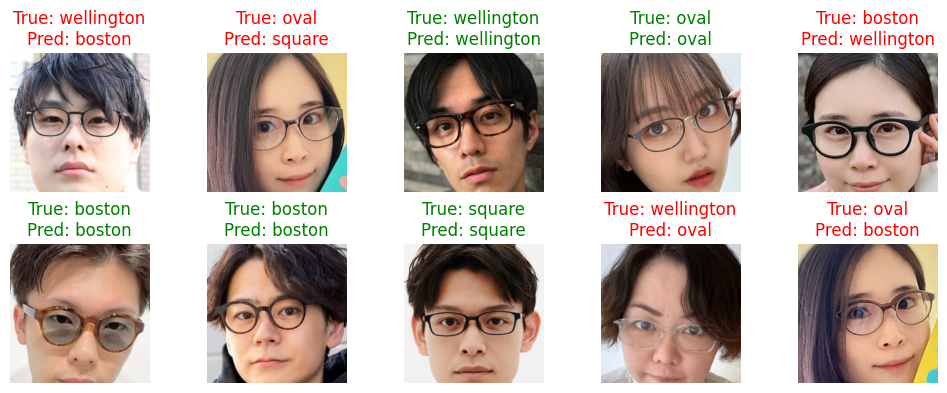


Class-wise accuracy for displayed samples:
oval: 33.3% (1/3)
wellington: 33.3% (1/3)
square: 100.0% (1/1)
boston: 66.7% (2/3)

Overall accuracy for these 10 samples: 50.0%


In [126]:
import torch
import matplotlib.pyplot as plt
import random
import numpy as np
from collections import defaultdict

def visualize_predictions(model, test_loader, processor, num_samples=10, device='cuda'):
    """
    テストデータからランダムに選んだサンプルの予測結果を可視化する。
    完全にランダムにサンプリングする。

    Args:
        model: 学習済みモデル
        test_loader: テストデータローダー
        processor: CLIPプロセッサー
        num_samples: 表示するサンプル数
        device: 使用デバイス
    """
    model.eval()

    # クラスラベルの定義
    class_names = model.class_names

    # すべてのサンプルを収集
    all_samples = []

    with torch.no_grad():
        for images, labels in test_loader:
            # 予測
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            # サンプルを保存
            for img, label, pred in zip(images.cpu(), labels.cpu(), preds.cpu()):
                all_samples.append({
                    'image': img,
                    'true_label': label.item(),
                    'pred_label': pred.item()
                })

    # ランダムにnum_samples個選択
    selected_samples = random.sample(all_samples, num_samples)

    # プロット
    fig = plt.figure(figsize=(10, 4))
    for idx, sample in enumerate(selected_samples):
        ax = plt.subplot(2, 5, idx + 1)

        # 画像の表示
        img = sample['image'].numpy()  # shape: (3, 224, 224)
        mean = np.array([0.48145466, 0.4578275, 0.40821073])[:, None, None]
        std = np.array([0.26862954, 0.26130258, 0.27577711])[:, None, None]

        # 正規化を戻す（チャンネルファースト形式で）
        img = std * img + mean

        # チャンネルラストに変換
        img = np.transpose(img, (1, 2, 0))

        # 値を0-1の範囲にクリップ
        img = np.clip(img, 0, 1)

        plt.imshow(img)

        # 予測とラベルの表示
        true_label = class_names[sample['true_label']]
        pred_label = class_names[sample['pred_label']]
        color = 'green' if true_label == pred_label else 'red'

        title = f'True: {true_label}\nPred: {pred_label}'
        ax.set_title(title, color=color)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

    # クラスごとの正解率を表示
    print("\nClass-wise accuracy for displayed samples:")
    class_correct = defaultdict(int)
    class_total = defaultdict(int)

    for sample in selected_samples:
        true_label = sample['true_label']
        class_total[true_label] += 1
        if sample['true_label'] == sample['pred_label']:
            class_correct[true_label] += 1

    for class_idx in range(len(class_names)):
        if class_total[class_idx] > 0:
            acc = (class_correct[class_idx] / class_total[class_idx]) * 100
            print(f"{class_names[class_idx]}: {acc:.1f}% ({class_correct[class_idx]}/{class_total[class_idx]})")

    # 全体の正解率
    total_correct = sum(class_correct.values())
    total_samples = sum(class_total.values())
    print(f"\nOverall accuracy for these {total_samples} samples: {(total_correct/total_samples)*100:.1f}%")

set_seed(1)

from transformers import CLIPProcessor

# モデルとプロセッサーの準備
model = GlassesClassifier(num_classes=4)
# モデルのロード
model = load_model(model, best_model_path_acc, device=device)

visualize_predictions(
    model=model,
    test_loader=test_loader,
    processor=processor,
    num_samples=10,
    device=device
)

In [107]:
# @title predict_one_shot.py

from transformers import CLIPProcessor

# モデルとプロセッサーの準備
model = GlassesClassifier(num_classes=4)
# モデルのロード
model = load_model(model, best_model_path_acc, device=device)

# プロセッサーの準備
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# 画像の予測
image_path = os.path.join(ROOT_PATH, 'data/test_images/square.jpg')
result = predict_one_shot(model, image_path, processor, device)

if 'error' in result:
    print(f"Error: {result['error']}")
else:
    print(f"Predicted class: {result['predicted_class']}")
    print(f"Confidence: {result['confidence']}%")
    print("\nAll class probabilities:")
    for class_name, prob in result['all_probabilities'].items():
        print(f"{class_name}: {prob}%")

<ipython-input-4-afde70759031>:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Loaded model from epoch 42 with validation accuracy: 61.03%
Predicted class: square
Confidence: 44.74%

All class probabilities:
oval: 9.71%
wellington: 36.57%
square: 44.74%
boston: 8.97%
